In [1]:
%matplotlib inline

### Load libraries

In [2]:
import tensorflow as tf
import numpy as np
import menpo.io as mio
from menpo.shape import PointCloud
from menpo.image import Image

### Auxiliary functions

In [3]:
def crop_face(img, boundary=50, group=None, shape=(256, 256), order=1):
    pc = img.landmarks[group]
    nan_points = np.any(np.isnan(pc.points).reshape(-1, 2), 1)

    pc = PointCloud(pc.points[~nan_points, :])
    min_indices, max_indices = pc.bounds(boundary=boundary)
    h = max_indices[0] - min_indices[0]
    w = max_indices[1] - min_indices[1]
    pad = abs(w - h)

    try:
        index = 1 - int(w > h)
        min_indices[index] -= int(pad / 2.)
        max_indices[index] += int(pad / 2.) + int(pad) % 2

        img = img.crop(min_indices, max_indices, constrain_to_boundary=True)
    except Exception as e:
        print("Exception in crop_face", e)

    img = img.resize(shape, order=order)
    return img

def normalise_vals(x):
    x = x - x.min()
    return x / x.max()

def std_normals(normals):
    normals = normals.copy()
    mask = normals.mask.pixels[0]
    normals.pixels[0, mask] = normalise_vals(normals.masked_pixels()[0])
    normals.pixels[1, mask] = normalise_vals(normals.masked_pixels()[1])
    normals.pixels[2, mask] = normalise_vals(normals.masked_pixels()[2]) / 2 + .5
    normals.pixels[:, ~mask] = 1
    return normals.as_unmasked()

### Declare model

In [4]:
image = tf.placeholder(tf.float32, shape=(None, None, 3), name='images')

MODEL_PATH = './normals_frozen.pb'

with open(MODEL_PATH, 'rb') as f:
    graph_def = tf.GraphDef.FromString(f.read())
    pred,  = tf.import_graph_def(graph_def,
                                 input_map={"images": image},
                                 return_elements=['final:0'])

### Load image

/vol/atlas/homes/gt108/Projects/menpo/menpo/io/input/base.py:26: MenpoDeprecationWarning: normalise is no longer supported and will be removed in a future version of Menpo. Use normalize instead.
  MenpoDeprecationWarning)


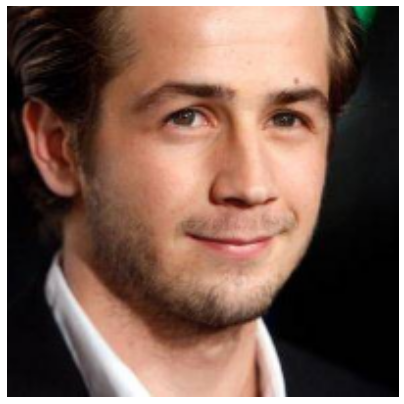

In [5]:
im = mio.import_images('/vol/atlas/databases/lfpw/trainset/', normalise=False)[55]
im = crop_face(im, shape=(200, 200))
im.view()

### Initialise session

In [6]:
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=config)

In [7]:
result = sess.run(pred, feed_dict={image: im.pixels_with_channels_at_back()})

In [8]:
normals = Image.init_from_channels_at_back(result[0])
normals.landmarks['PTS'] = im.landmarks[None]
normals = normals.as_masked()
normals = normals.constrain_mask_to_landmarks()

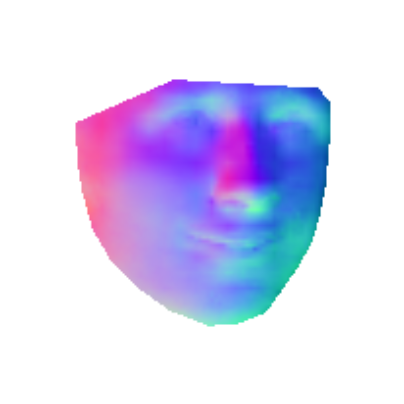

In [9]:
std_normals(normals).view()